## C S 329E HW 9

# Clustering with DBSCAN

## Elena Zhang, Emily Zhou

As we discussed in lecture DBSCAN creates clusters based on the density of the points in the vicinity of the data.  Using small example data sets, we will implement both algorithms and visualize the results.

Even though the example data is small and 2 dimensional, write your helper functions to not assume a 2-D data set.  Your plotting code can reference the `x` and `y` column names from the sample data directly. 

Note that I have added a one or two lines of code to the questions to test your implementations. 

In [1]:
# Do not import anything else
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN # only on last problem

# DBSCAN

## Q1 Load the Density Data and try K-means

Load in the data provided `data_dbscan.csv`, cluster it with k-means algorithm with $k=2$ and visualize the results with a scatter plot, where the color indicates cluster membership. Label your axes, and give the plot a title. Use the [scikit-learn implementation of K-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

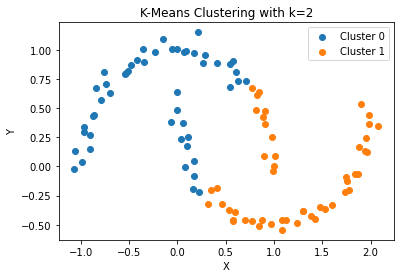

In [2]:
df_dbscan = pd.read_csv('data_dbscan.csv')

# Call k_means with k = 2
df_kmeans = df_dbscan.copy()
kmeans = KMeans(n_clusters=2).fit(df_kmeans)  #create k-means model
df_kmeans['K-means Label'] = kmeans.labels_   #add cluster labels to dataframe

#plot each cluster
for cluster_id in np.unique(kmeans.labels_):
    cluster = df_kmeans[df_kmeans['K-means Label'] == cluster_id] #find clusters
    lab = "Cluster " + str(cluster_id) # Cluster label for legend
    plt.scatter(cluster['x'], cluster['y'], label = lab) # plot cluster

#add plot descriptions
plt.xlabel('X')
plt.ylabel('Y')
plt.title('K-Means Clustering with k=2')
plt.legend()
plt.show()

## Q2.2 Write function to Implement Range Query

Using the [pseudo-code](https://en.wikipedia.org/wiki/DBSCAN#Algorithm) on wikipedia, implement RangeQuery.

```
RangeQuery(DB, distFunc, Q, eps) {
    Neighbors N := empty list
    for each point P in database DB {                      /* Scan all points in the database */
        if distFunc(Q, P) ≤ eps then {                     /* Compute distance and check epsilon */
            N := N ∪ {P}                                   /* Add to result */
        }
    }
    return N
}
```

The "DB" parameter is a data frame, `df_data` containing all of the points in our data set, the "distFunc" is set as Euclidean distance thus should not be passed in, the point "Q", is represented by the index of the data frame, `q_index`, where `df_data.iloc[q_index]` is the actual point, and `eps` is a floating point value that indicates the radius from the point "Q" to search for neighbors.  The function will return the slice of `df_data` of all points within `eps` distance of "Q" (including "Q").  The indices on the slice should be preserved (do not reset_index).  

In [3]:
def range_query( df_data, q_index, eps ):
    # your code here
    neighbors = []
    #loop through dataframe to calculate distance between selected point
    for idx, row in df_data.iterrows():
        dist = np.linalg.norm(row - df_data.iloc[q_index])
        #save the rows that are within eps distance
        if dist <= eps:
            neighbors.append(row)
            
    #return slice of df_data of all points within eps distance from point q_index
    return pd.DataFrame(neighbors)

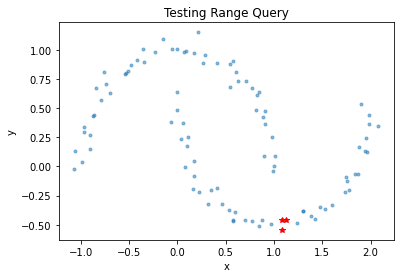

In [4]:
# Test it out
df_n = range_query( df_dbscan, 0, 0.1 )
plt.plot( df_dbscan['x'], df_dbscan['y'], '.', alpha = 0.5 )
plt.plot( df_n['x'], df_n['y'], 'r*')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Testing Range Query')
plt.show()

## Q2.3 Write a function to implement DBSCAN

Using the [pseudo-code](https://en.wikipedia.org/wiki/DBSCAN#Algorithm) on wikipedia, implement DBSCAN. This algorithm uses set notation, I found a handy summary on-line [here](http://www.math.cmu.edu/~bkell/21110-2010s/sets.html) if you need a refresher. 

```
DBSCAN(DB, distFunc, eps, minPts) {
    C := 0                                                  /* Cluster counter */
    for each point P in database DB {
        if label(P) ≠ undefined then continue               /* Previously processed in inner loop */
        Neighbors N := RangeQuery(DB, distFunc, P, eps)     /* Find neighbors */
        if |N| < minPts then {                              /* Density check */
            label(P) := Noise                               /* Label as Noise */
            continue
        }
        C := C + 1                                          /* next cluster label */
        label(P) := C                                       /* Label initial point */
        SeedSet S := N \ {P}                                /* Neighbors to expand */
        for each point Q in S {                             /* Process every seed point Q */
            if label(Q) = Noise then label(Q) := C          /* Change Noise to border point */
            if label(Q) ≠ undefined then continue           /* Previously processed (e.g., border point) */
            label(Q) := C                                   /* Label neighbor */
            Neighbors N := RangeQuery(DB, distFunc, Q, eps) /* Find neighbors */
            if |N| ≥ minPts then {                          /* Density check (if Q is a core point) */
                S := S ∪ N                                  /* Add new neighbors to seed set */
            }
        }
    }
}
```

The function should accept as parameters "DB", a data frame of points to be clustered, `df_data`, no distance function (assuming Euclidean distance), a floating point `eps` that defines the radius, and an integer `minPts`.  The function will return a series of cluster assignments of the same length as `df_data`. If the data is classified as noise, the cluster assignment is $0$, and all of the clusters will have a label of $1-k$, were $k$ is derived in the function and represents the total number of clusters found. 

Don't forget that [iterrows](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iterrows.html) is a lovely way to loop through a data frame. But if you modify the dataframe within the loop, it doesn't add more iterations to the loop.  For example, if you start with a dataframe of length $n$ and add $3$ rows, then the `iterrows` will stop after $n$ rows. For the inside loop, you'll need to use a native python list to dynamically grow the `SeedSet S`.  You can use the `extend` function to merge 2 lists together. For example:

```
x = [1,2,3]
y = [4,5,6]
x.extend(y) # sets x to the list [1, 2, 3, 4, 5, 6]
```

If you haven't used the [continue](https://docs.python.org/3/tutorial/controlflow.html) statement before, it can be useful in these situations, check out the link. 

Call `dbscan` with the `df_dbscan` data frame, `eps` set to 0.23, and `min_pts` set to 6 and save the results to `s_cluster_assignments` 

In [5]:
def dbscan( df_data, eps, min_pts ):
    NOISE_LABEL = 0
    C = 0  #cluster count
    
    #add label column
    df_copy = df_data.copy()
    df_copy['label'] = ''

    for idx,row in df_copy.iterrows():
                    
        if df_copy['label'][idx] != '':          #Previously processed in inner loop 
            continue      
        neighbors = range_query(df_data, idx, eps)    #find neighbors
        if len(neighbors) < min_pts:                   #check density
            df_copy['label'][idx] = NOISE_LABEL      #label as noise
            continue     
            
        C = C + 1                                   #next cluster label
        df_copy['label'][idx] = C                    #label initial point
        seedSet = [i for i,n in neighbors.iterrows() if i != idx]  #Neighbors to expand

        for Q in seedSet:                           #process every seed point Q
            if df_copy['label'][Q] == NOISE_LABEL:
                df_copy['label'][Q] = C            #change noise to border point
                
            if df_copy['label'][Q] != '':
                continue                        #Previously processed (e.g., border point)
            
            df_copy['label'][Q] = C             #label neighbor
            neighbors = range_query(df_data, Q, eps) #find neighbors
            if len(neighbors) >= min_pts:            #Density check (if Q is a core point)
                seedSet.extend(neighbors.index.values.tolist()) #add new neighbors to see set

    return df_copy['label']

In [6]:
# Test it out
s_cluster_assignment = dbscan( df_dbscan, 0.23, 6)
s_cluster_assignment.value_counts()

<ipython-input-5-2896754d3f48>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['label'][idx] = C                    #label initial point
<ipython-input-5-2896754d3f48>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['label'][Q] = C             #label neighbor
<ipython-input-5-2896754d3f48>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['label'][idx] = NOISE_LABEL      #label as noise
<ipython-input-5-2896

1    49
2    48
0     3
Name: label, dtype: int64

## Q2.4 Plot the Results 

Plot the points in the `df_dbscan` data frame using a 2-D scatter plot, with a different color for each cluster.  Use the cluster assignments from the previous problem (`s_cluster_assignments`). Label your axes, and give the plot a title.

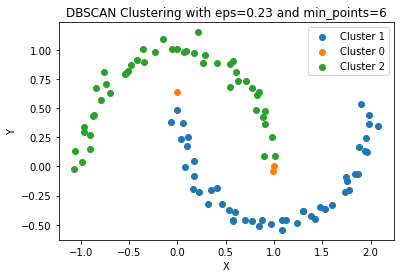

In [7]:
# add cluster label to original data frame
df_dbscan_copy = df_dbscan.copy()
df_dbscan_copy['cluster label'] = s_cluster_assignment

# Plot each cluster
for cluster_id in s_cluster_assignment.unique():
    cluster = df_dbscan_copy[df_dbscan_copy['cluster label'] == cluster_id]
    lab = "Cluster " + str(cluster_id) # Cluster label for legend
    plt.scatter(cluster['x'], cluster['y'], label = lab) # plot cluster

#add plot descriptions
plt.xlabel('X')
plt.ylabel('Y')
plt.title('DBSCAN Clustering with eps=0.23 and min_points=6')
plt.legend()
plt.show()

## Q2.5 Compare your results to the scikit-learn library

Import DBSCAN from scikit-learn and compare the cluster labels from your implementation to the cluster labels generated from [scikit-learn's DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). Add some commentary about how you think the results compare. Use the same data and values for eps and minPts.

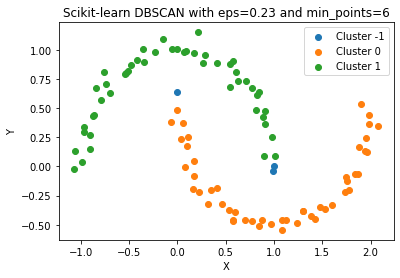

In [8]:
# check your implementation vs scikit-learn
from sklearn.cluster import DBSCAN
# your code here
clustering = DBSCAN(eps=.23, min_samples=6).fit(df_dbscan)
df_dbscan['cluster Label'] = clustering.labels_   #add cluster labels to dataframe

#plot each cluster
for cluster_id in np.unique(clustering.labels_):
    cluster = df_dbscan[df_dbscan['cluster Label'] == cluster_id] #find clusters
    lab = "Cluster " + str(cluster_id) # Cluster label for legend
    plt.scatter(cluster['x'], cluster['y'], label = lab) # plot cluster

#add plot descriptions
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scikit-learn DBSCAN with eps=0.23 and min_points=6')
plt.legend()
plt.show()



Both scikit-learn's clustering and our implementation appear to look the same with 2 clusters and 3 noise points. One noticeable difference is the cluster labels used are different. Scikit-learn uses label numbers -1 to 1 while we used label numbers 0 to 2. Scikit-learn uses -1 for noise points while we use 0.